Task 1: Effect of Number of Tellers

Simulation with 1 Tellers:

Waiting Time Analysis:
Average Waiting Time: 8.12 minutes
Maximum Waiting Time: 15.08 minutes


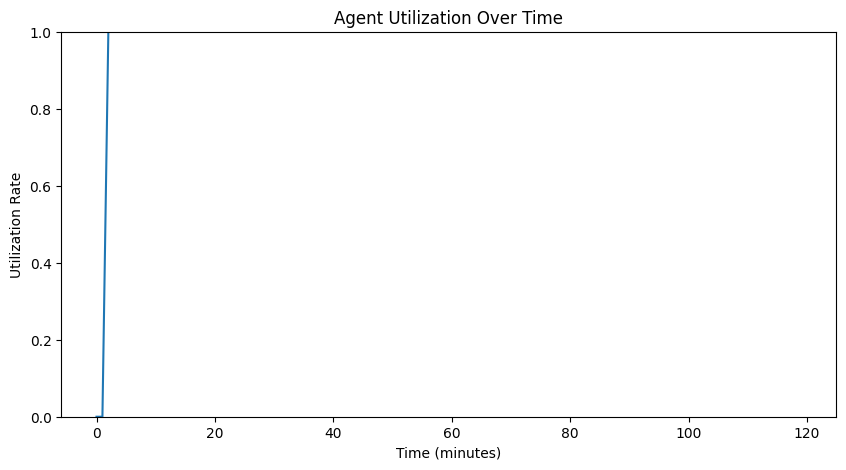


Simulation with 3 Tellers:

Waiting Time Analysis:
Average Waiting Time: 0.06 minutes
Maximum Waiting Time: 1.25 minutes


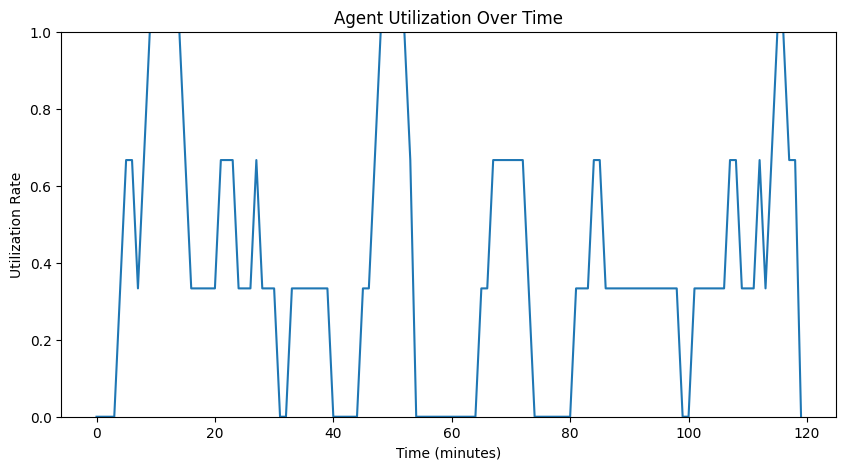


Simulation with 5 Tellers:

Waiting Time Analysis:
Average Waiting Time: 0.00 minutes
Maximum Waiting Time: 0.00 minutes


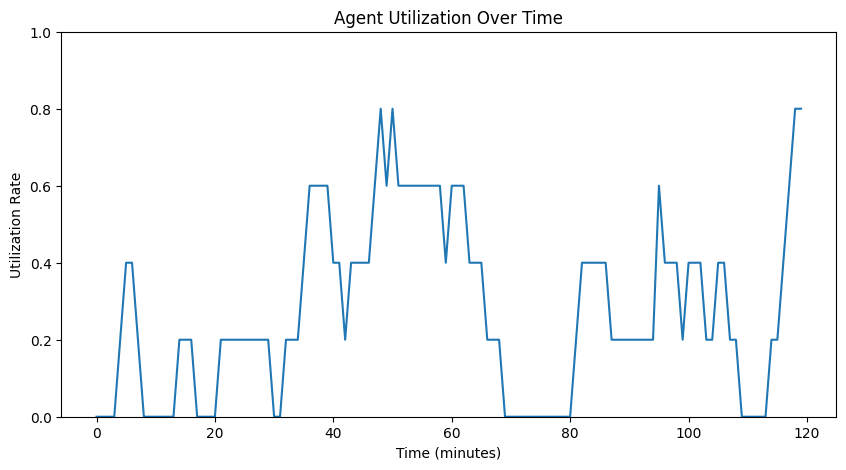


Simulation with 7 Tellers:

Waiting Time Analysis:
Average Waiting Time: 0.00 minutes
Maximum Waiting Time: 0.00 minutes


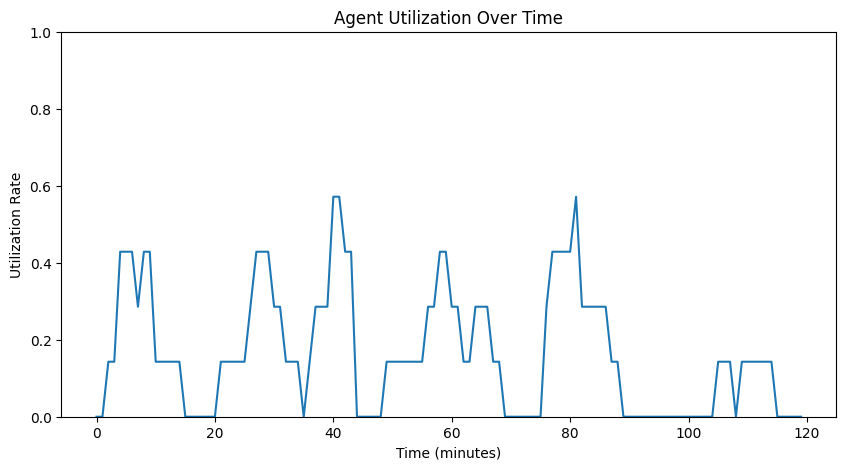


Task 2: Peak Hours Simulation

Simulation with Arrival Rate 0.1:

Waiting Time Analysis:
Average Waiting Time: 0.00 minutes
Maximum Waiting Time: 0.00 minutes


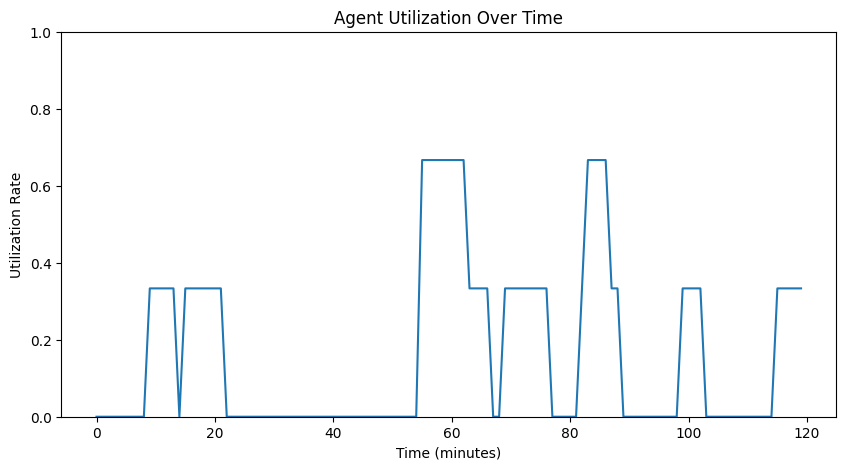


Simulation with Arrival Rate 0.3:

Waiting Time Analysis:
Average Waiting Time: 1.12 minutes
Maximum Waiting Time: 5.88 minutes


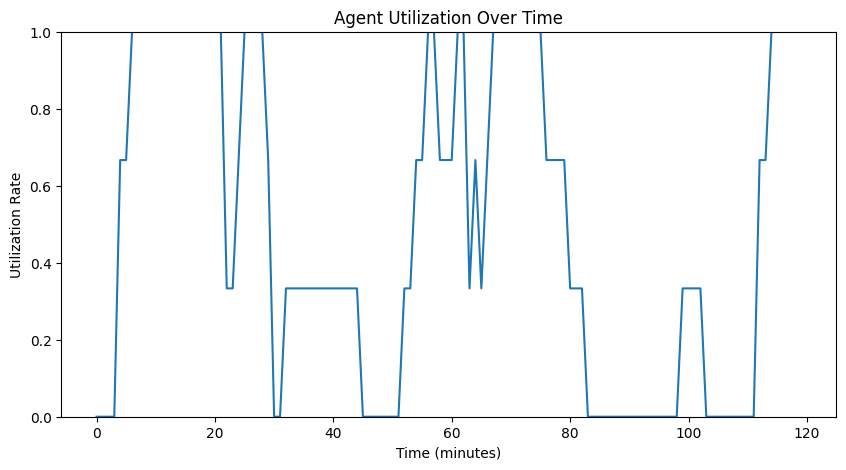


Simulation with Arrival Rate 0.5:

Waiting Time Analysis:
Average Waiting Time: 2.32 minutes
Maximum Waiting Time: 8.98 minutes


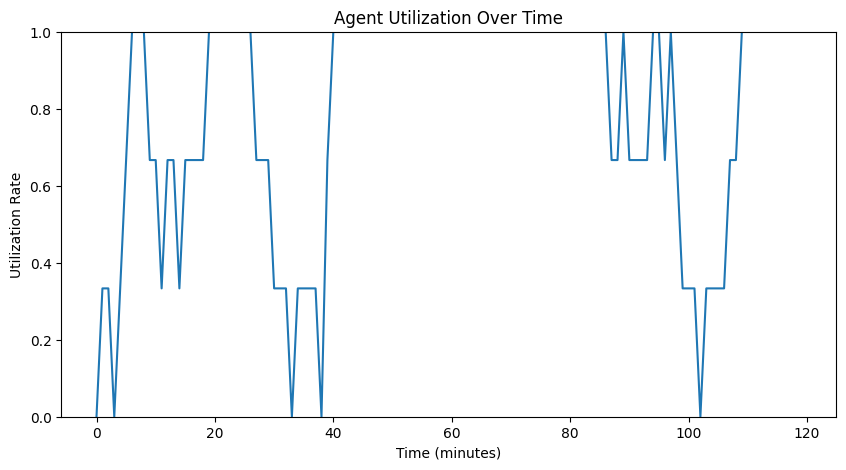


Task 4: Priority Queue Simulation

Priority Queue Analysis:
Regular Customers:
  Average Waiting Time: 0.83 minutes
  Maximum Waiting Time: 4.26 minutes
  Total Regular Customers: 33

VIP Customers:
  Average Waiting Time: 0.15 minutes
  Maximum Waiting Time: 0.45 minutes
  Total VIP Customers: 3


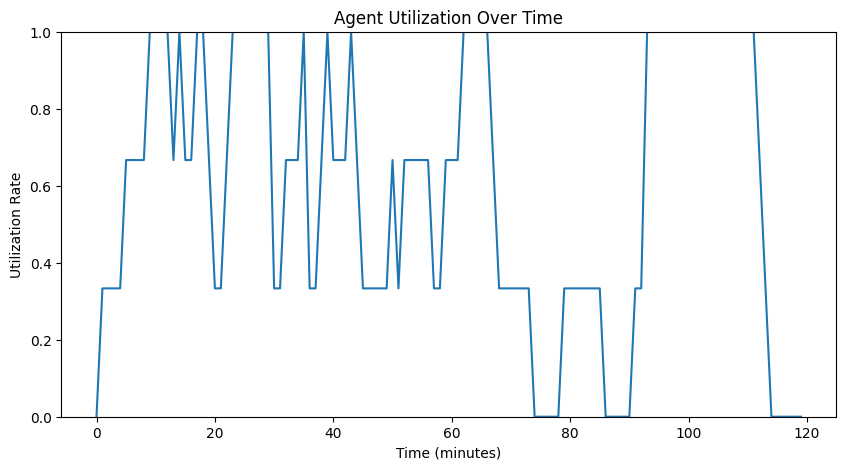

In [10]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

class BankSimulation:
    def __init__(self, num_tellers, simulation_time, arrival_rate):
        self.env = simpy.Environment()
        self.num_tellers = num_tellers
        self.simulation_time = simulation_time
        self.arrival_rate = arrival_rate
        self.teller_resource = simpy.Resource(self.env, capacity=num_tellers)
        self.waiting_times = []
        self.service_times = []
        self.agent_utilization = []

    def customer(self, name, service_time):
        # Record arrival time
        arrival_time = self.env.now
        
        # Request a teller
        with self.teller_resource.request() as request:
            yield request
            
            # Wait time calculation
            wait_time = self.env.now - arrival_time
            self.waiting_times.append(wait_time)
            
            # Service time
            yield self.env.timeout(service_time)
            
            # Record service time
            self.service_times.append(service_time)

    def customer_generator(self):
        customer_id = 0
        while self.env.now < self.simulation_time:
            # Exponential distribution for inter-arrival times
            yield self.env.timeout(random.expovariate(self.arrival_rate))
            
            # Random service time (between 2-10 minutes)
            service_time = random.uniform(2, 10)
            
            customer_id += 1
            self.env.process(self.customer(f'Customer {customer_id}', service_time))

    def record_agent_utilization(self):
        while self.env.now < self.simulation_time:
            # Calculate current utilization
            utilization = len(self.teller_resource.users) / self.num_tellers
            self.agent_utilization.append((self.env.now, utilization))
            yield self.env.timeout(1)  # Check every minute

    def run(self):
        # Start customer generator and utilization tracker
        self.env.process(self.customer_generator())
        self.env.process(self.record_agent_utilization())
        
        # Run the simulation
        self.env.run(until=self.simulation_time)

    def analyze_results(self):
        # Task 1: Analyze waiting times
        print(f"\nWaiting Time Analysis:")
        print(f"Average Waiting Time: {np.mean(self.waiting_times):.2f} minutes")
        print(f"Maximum Waiting Time: {np.max(self.waiting_times):.2f} minutes")

        # Task 3: Visualize agent utilization
        times, utilizations = zip(*self.agent_utilization)
        plt.figure(figsize=(10, 5))
        plt.plot(times, utilizations)
        plt.title('Agent Utilization Over Time')
        plt.xlabel('Time (minutes)')
        plt.ylabel('Utilization Rate')
        plt.ylim(0, 1)
        plt.show()

# Task 1: Changing number of tellers
def test_different_tellers():
    print("Task 1: Effect of Number of Tellers")
    teller_configs = [1, 3, 5, 7]
    for num_tellers in teller_configs:
        print(f"\nSimulation with {num_tellers} Tellers:")
        sim = BankSimulation(num_tellers=num_tellers, 
                             simulation_time=120, 
                             arrival_rate=0.2)  # 1 customer every 5 minutes on average
        sim.run()
        sim.analyze_results()

# Task 2: Simulating peak hours
def test_peak_hours():
    print("\nTask 2: Peak Hours Simulation")
    # Lower arrival rate (less busy) and higher arrival rate (peak hours)
    arrival_rates = [0.1, 0.3, 0.5]
    for rate in arrival_rates:
        print(f"\nSimulation with Arrival Rate {rate}:")
        sim = BankSimulation(num_tellers=3, 
                             simulation_time=120, 
                             arrival_rate=rate)
        sim.run()
        sim.analyze_results()

# Task 4: Priority Queue Simulation
class PriorityBankSimulation:
    def __init__(self, num_tellers, simulation_time, arrival_rate):
        self.env = simpy.Environment()
        self.num_tellers = num_tellers
        self.simulation_time = simulation_time
        self.arrival_rate = arrival_rate
        self.teller_resource = simpy.PriorityResource(self.env, capacity=num_tellers)
        self.waiting_times = {
            'regular': [],
            'vip': []
        }
        self.service_times = []
        self.agent_utilization = []

    def customer(self, name, service_time, is_vip=False):
        # Record arrival time
        arrival_time = self.env.now
        
        # Determine priority (lower number = higher priority)
        priority = 0 if is_vip else 1
        
        # Request a teller with priority
        with self.teller_resource.request(priority=priority) as request:
            yield request
            
            # Wait time calculation
            wait_time = self.env.now - arrival_time
            
            # Store wait time based on customer type
            if is_vip:
                self.waiting_times['vip'].append(wait_time)
            else:
                self.waiting_times['regular'].append(wait_time)
            
            # Service time
            yield self.env.timeout(service_time)
            
            # Record service time
            self.service_times.append(service_time)

    def customer_generator(self):
        customer_id = 0
        while self.env.now < self.simulation_time:
            # Exponential distribution for inter-arrival times
            yield self.env.timeout(random.expovariate(self.arrival_rate))
            
            # Random service time (between 2-10 minutes)
            service_time = random.uniform(2, 10)
            
            customer_id += 1
            
            # 20% of customers are VIP
            is_vip = random.random() < 0.2
            
            # Process the customer
            customer_type = 'VIP' if is_vip else 'Regular'
            self.env.process(self.customer(f'{customer_type} Customer {customer_id}', 
                                           service_time, 
                                           is_vip=is_vip))

    def record_agent_utilization(self):
        while self.env.now < self.simulation_time:
            # Calculate current utilization
            utilization = len(self.teller_resource.users) / self.num_tellers
            self.agent_utilization.append((self.env.now, utilization))
            yield self.env.timeout(1)  # Check every minute

    def run(self):
        # Start customer generator and utilization tracker
        self.env.process(self.customer_generator())
        self.env.process(self.record_agent_utilization())
        
        # Run the simulation
        self.env.run(until=self.simulation_time)

    def analyze_results(self):
        # Analyze waiting times for regular and VIP customers
        print("\nPriority Queue Analysis:")
        
        # Regular Customers
        if self.waiting_times['regular']:
            print("Regular Customers:")
            print(f"  Average Waiting Time: {np.mean(self.waiting_times['regular']):.2f} minutes")
            print(f"  Maximum Waiting Time: {np.max(self.waiting_times['regular']):.2f} minutes")
            print(f"  Total Regular Customers: {len(self.waiting_times['regular'])}")
        
        # VIP Customers
        if self.waiting_times['vip']:
            print("\nVIP Customers:")
            print(f"  Average Waiting Time: {np.mean(self.waiting_times['vip']):.2f} minutes")
            print(f"  Maximum Waiting Time: {np.max(self.waiting_times['vip']):.2f} minutes")
            print(f"  Total VIP Customers: {len(self.waiting_times['vip'])}")

        # Visualize agent utilization
        if self.agent_utilization:
            times, utilizations = zip(*self.agent_utilization)
            plt.figure(figsize=(10, 5))
            plt.plot(times, utilizations)
            plt.title('Agent Utilization Over Time')
            plt.xlabel('Time (minutes)')
            plt.ylabel('Utilization Rate')
            plt.ylim(0, 1)
            plt.show()

def test_priority_queue():
    print("\nTask 4: Priority Queue Simulation")
    sim = PriorityBankSimulation(num_tellers=3, 
                                 simulation_time=120, 
                                 arrival_rate=0.3)
    sim.run()
    sim.analyze_results()

# Run all tasks
if __name__ == "__main__":
    test_different_tellers()
    test_peak_hours()
    test_priority_queue()